# Data preprocessing

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 50)

clinical_data = pd.read_excel("TRAIN/Training_Unlabeled_Clinical_Data.xlsx")
biomarker_data = pd.read_csv("TRAIN/Training_Biomarker_Data.csv")

# Extract Meta Data
meta = clinical_data["File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
clinical_data[meta.columns] = meta

# Fix missing meta columns
idx = clinical_data["Image_Name"].isna()
clinical_data.loc[idx, ["Folder", "Visit", "Eye", "Image_Name"]] = clinical_data.loc[idx, ["Arm", "Folder", "Visit", "Eye"]].values
clinical_data.loc[idx, "Arm"] = None

columns = biomarker_data.columns.tolist()
columns[0] = clinical_data.columns[0]
biomarker_data.columns = columns

biomarker_clinical = pd.merge(biomarker_data, clinical_data, on="File_Path", how="left")

missing_idx = lambda x: x["Eye_ID"].isna()

meta = biomarker_clinical.loc[missing_idx, "File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Folder", "Visit", "Eye", "Image_Name"]
biomarker_clinical.loc[missing_idx, meta.columns] = meta

biomarker_clinical.loc[missing_idx, "Eye_ID"] = 79
biomarker_clinical = biomarker_clinical.drop(['Patient_ID', 'BCVA', 'CST'], axis = 1)
biomarker_clinical["File_Path"] = "TRAIN/OLIVES" + biomarker_clinical["File_Path"]

In [2]:
test_df = pd.read_csv('test_set_labels.csv')
columns = test_df.columns.tolist()
columns[0] = clinical_data.columns[0]
test_df.columns = columns

test_df["File_Path"] = "/" + test_df["File_Path"]
#meta = test_df["File_Path"].str.split("/", expand=True)
#meta = meta.drop(0, axis=1)
#meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
#test_df[meta.columns] = meta
test_df["File_Path"] = "TEST" + test_df["File_Path"]

In [3]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

labels = ["B1", "B2", "B3", "B4", "B5", "B6"]

eye_ids = biomarker_clinical.groupby("Eye_ID")[["B1", "B2", "B3", "B4", "B5", "B6"]].mean().round().astype(int)

mskf = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=3000)

train_index, test_index = next(iter(mskf.split(eye_ids.index, eye_ids)))

In [4]:
train_ids, val_ids = eye_ids.index[train_index], eye_ids.index[test_index]
train_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(train_ids), ["File_Path"] + labels]
val_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(val_ids), ["File_Path"] + labels]

In [5]:
import numpy as np
filtered_values = np.where((test_df['B1'] == 0) & (test_df['B2'] == 1))

In [6]:
filtered_test_df = test_df.loc[filtered_values]

In [7]:
train_df = pd.concat([train_df, filtered_test_df])

In [8]:
train_df["B1"].value_counts(), train_df["B2"].value_counts(), train_df["B3"].value_counts(), train_df["B4"].value_counts(), train_df["B5"].value_counts(), train_df["B6"].value_counts()

(1    5525
 0    3568
 Name: B1, dtype: int64,
 0    5616
 1    3477
 Name: B2, dtype: int64,
 1    4628
 0    4465
 Name: B3, dtype: int64,
 0    6396
 1    2697
 Name: B4, dtype: int64,
 0    6434
 1    2659
 Name: B5, dtype: int64,
 0    5497
 1    3596
 Name: B6, dtype: int64)

In [9]:
biomarker_clinical["B1"].value_counts(), biomarker_clinical["B2"].value_counts(), biomarker_clinical["B3"].value_counts(), biomarker_clinical["B4"].value_counts(), biomarker_clinical["B5"].value_counts(), biomarker_clinical["B6"].value_counts()

(1    6341
 0    3067
 Name: B1, dtype: int64,
 0    6424
 1    2984
 Name: B2, dtype: int64,
 1    5222
 0    4186
 Name: B3, dtype: int64,
 0    6572
 1    2836
 Name: B4, dtype: int64,
 0    6405
 1    3003
 Name: B5, dtype: int64,
 0    5320
 1    4088
 Name: B6, dtype: int64)

In [10]:
import torch
pos_weight_one = 3067/6371
pos_weight_two = 6424/2984
pos_weight_three = 4186/5222
pos_weight_four = 6572/2836
pos_weight_five = 6405/3003
pos_weight_six = 5320/4088
pos_weight = torch.tensor([pos_weight_one, pos_weight_two, pos_weight_three, pos_weight_four, pos_weight_five, pos_weight_six])

# Initialization

In [11]:
%matplotlib inline
from PIL import Image
import torch.utils.data as data
import os
import math
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torchsummary import summary
import torch
import torchvision
from sklearn.metrics import accuracy_score
# import skimage
from skimage.io import imread
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import time
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics

In [12]:
import os
import random

import numpy as np
import torch

SEED = 3000

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [13]:
from __future__ import print_function

import math
import numpy as np
import torch
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

# Data Loader 

In [14]:
class OLIVES(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor
    
class RECOVERY(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image

In [15]:
normalize = transforms.Normalize(mean=.1706, std=.2112)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])
val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.ToTensor(),
        normalize,
    ])

In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
train_dataset = OLIVES(train_df, transforms = train_transform)
validation_dataset = OLIVES(val_df, transforms = val_transform)

In [18]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True)

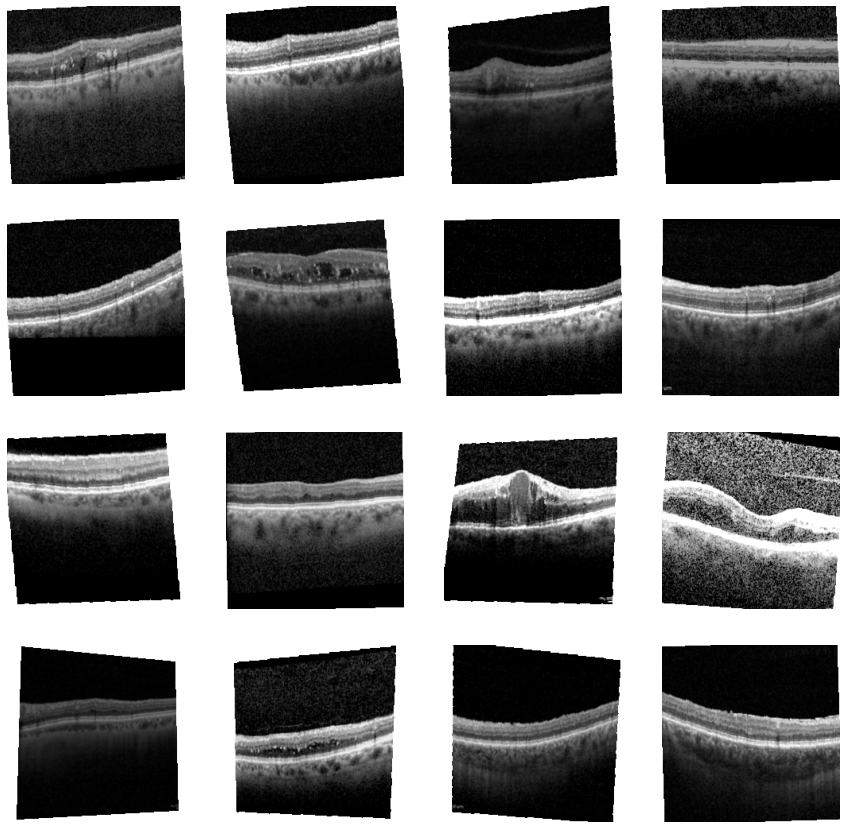

In [19]:
# Plot more images
torch.manual_seed(SEED+1)
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False);

# Device

In [20]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Model 

In [21]:
model = torchvision.models.resnet50(weights=None,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [22]:
ckpt = torch.load("models/18_vip_cup_student_one_pretrain_random_weight_epoch_21.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1219, -0.0029,  0.0824,  ...,  0.0915, -0.1335, -0.1394],
                        [-0.0145, -0.0247,  0.0919,  ...,  0.0266,  0.1263,  0.0105],
                        [-0.0812,  0.1037,  0.0073,  ..., -0.0042,  0.0200, -0.1304],
                        ...,
                        [ 0.0325, -0.0360, -0.0480,  ..., -0.0820, -0.1097, -0.0472],
                        [-0.0620,  0.0460,  0.1854,  ...,  0.2097,  0.1610,  0.1376],
                        [-0.0671,  0.0358, -0.0565,  ...,  0.0389,  0.0882,  0.1363]]],
              
              
                      [[[ 0.1979,  0.1476, -0.0673,  ..., -0.0719, -0.0721, -0.1606],
                        [ 0.1724,  0.1653,  0.0129,  ..., -0.1447, -0.0800, -0.1368],
                        [ 0.0532, -0.0873,  0.0404,  ...,  0.0460,  0.0089, -0.1782],
                        ...,
                        [-0.0410,  0.0265, -0.0870,  ..., -0.1178,  0.0820, -0.0016],
                    

# Criterion, Optimizer

In [23]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# Balanced accuracy score

In [24]:
from sklearn.metrics import balanced_accuracy_score

def compute_balanced_accuracy(truths, outputs):
    
    return [
        round(balanced_accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [25]:
def compute_accuracy_score(truths, outputs):
    
    return [
        round(accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [26]:
def compute_sensitivity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [27]:
def compute_specificity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred, pos_label=0), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [28]:
def custom_metric(x, y):
    x = np.transpose(x)
    y = np.transpose(y)
    
    return [
        round((2*(a*b)/(a+b)).item(), 4)
        for a, b in zip(x, y)
    ]

# Training

In [29]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True)

In [ ]:
# training routine
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

epochs = 100
t_loss = []
v_loss = []
accur = []
bal_accur = []
custom = []
s1 = []
s2 = []
for epoch in range(1, epochs + 1):
    # train
    model.train()
    #classifier.train()
    Train_losses = AverageMeter()
    
    for idx, (image, bio_tensor) in enumerate(train_loader):
        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss


        #features = model(images)
        output = model(images)
        
        loss = criterion(output, labels)
        
        # update metric
        Train_losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Val_losses = AverageMeter()
    y_true = []
    y_pred = []
    model.eval()
    #classifier.eval()    
    for idx, (image, bio_tensor) in enumerate(validation_loader):
        # Validation

        with torch.inference_mode():
            images = image.to(device)

            labels = bio_tensor.float()

            labels = labels.to(device)
            bsz = labels.shape[0]

            # compute loss


            #features = model(images)
            output = model(images)
            loss = criterion(output, labels)
            
            
            output = torch.round(torch.sigmoid(output))
            output = output.squeeze().detach().cpu().numpy()
            labels = labels.squeeze().detach().cpu().numpy()
            y_true.append(labels)
            y_pred.append(output)
            Val_losses.update(loss.item(), bsz)
    
    test_true = np.transpose(y_true)
    test_pred = np.transpose(y_pred)
    acc = compute_accuracy_score(test_true, test_pred)
    balanced_acc = compute_balanced_accuracy(test_true, test_pred)
    sen = compute_sensitivity(test_true, test_pred)
    spe = compute_specificity(test_true, test_pred)
    cus_met = custom_metric(sen, spe)
    
    t_loss.append(Train_losses.avg)
    v_loss.append(Val_losses.avg)
    accur.append(np.mean(acc))
    bal_accur.append(np.mean(balanced_acc))
    custom.append(np.mean(cus_met))
    s1.append(np.mean(sen))
    s2.append(np.mean(spe))
    print('-' * 10)
    print(f"{epoch}/{epochs}")
    print(f"Train loss: {Train_losses.avg:.5f} | Validation loss: {Val_losses.avg:.5f}")
    print(f"Accuracy: {acc} | Mean Accuracy: {np.mean(acc):.5f}")       
    print("Balanced acc (val): {} | Mean Balanced acc (val): {:.4f}".format(balanced_acc, np.mean(balanced_acc)))
    print(f"Sensitivity: {sen} | Mean Sensitivity: {np.mean(sen):.5f}")
    print(f"Specificity: {spe} | Mean Specificity: {np.mean(spe):.5f}")
    print(f"Custom Metric: {cus_met} | Mean Custom Metric: {np.mean(cus_met):.5f}")
    print('-' * 10)
    if epoch % 1 == 0:
        MODEL_NAME = f"18_vip_cup_student_one_finetune_random_weight_epoch_{epoch}.pth"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        state = {'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'epoch': epoch,
                }
        # Save the model state dict
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(state,
                   f=MODEL_SAVE_PATH)
        del state      

In [ ]:
plt.figure(figsize=(15, 7))

    # Plot loss
plt.plot(range(len(t_loss)), t_loss, label='train_loss')
plt.plot(range(len(v_loss)), v_loss, label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(accur)), accur, label='Accuracy')
plt.plot(range(len(bal_accur)), bal_accur, label='Balanced Accuracy')
plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(s1)), s1, label='Sensitivity')
plt.plot(range(len(s2)), s2, label='Specificity')
#plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [37]:
ckpt = torch.load("models/18_vip_cup_student_one_finetune_random_weight_epoch_26.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0650,  0.0131,  0.0507,  ...,  0.0496, -0.1202, -0.1044],
                        [ 0.0047, -0.0146,  0.0789,  ...,  0.0157,  0.1397,  0.0286],
                        [-0.0474,  0.1103,  0.0121,  ..., -0.0358, -0.0285, -0.1382],
                        ...,
                        [ 0.0582,  0.0043, -0.0336,  ..., -0.1148, -0.1569, -0.0829],
                        [-0.0429,  0.0705,  0.1897,  ...,  0.3095,  0.2472,  0.1511],
                        [-0.0793,  0.0089, -0.1008,  ...,  0.0537,  0.0997,  0.0683]]],
              
              
                      [[[ 0.2700,  0.1751, -0.1202,  ..., -0.1126, -0.1174, -0.1951],
                        [ 0.2246,  0.2048, -0.0123,  ..., -0.1493, -0.0906, -0.1504],
                        [ 0.0296, -0.1014,  0.0294,  ...,  0.0669,  0.0021, -0.1897],
                        ...,
                        [-0.0491,  0.0196, -0.0875,  ..., -0.0995,  0.1000,  0.0338],
                    

In [38]:
test_csv_path = 'TEST/test_set_submission_template.csv'
test_image_path = 'TEST/'

In [39]:
class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image, idx

In [40]:
test_dataset = RECOVERY(test_csv_path, test_image_path, val_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True,drop_last=False)

In [41]:
submission = pd.read_csv(test_csv_path)

In [42]:
model.eval()
with torch.no_grad():
    for idx, (image, index) in (enumerate(test_dataloader)):
        images = image.float().to(device)
        output = model(images)
        output = torch.round(torch.sigmoid(output))
        output = output.squeeze().cpu().numpy()
        index = int(index.numpy()[0])
        submission.iloc[index, 1:] = output

In [43]:
submission.to_csv('sub_eighten.csv', index=None)